## Problem set 2

In [458]:
import numpy as np
import matplotlib.pyplot as plt

### Problem 2.2 Restricted three-body problem

In [459]:
from scipy import integrate

In [460]:
class ThreeBody:
    def __init__(self):
        self.G = 4 * np.pi**2 # (AU^3)*(m_s^-1)*(yr^−2) gravitational constant 
        # -- SUN --
        self.r0 = 0 #sun fixed in origin
        self.m0 = 1 #solar mass
        self.R_01 = 1 #AU sun–earth distance
        # -- EARTH --
        self.T1 = 1 #yr earth year
        self.m1 = 3*10**-6 #mass of earth
        # -- MOON --
        self.T2 = 27.3/365.3 #yr moon’s orbital period
        self.m2 = 3.69*10**-8 #mass of moon
        self.R_12 = 2.57*10**-3 #AU earth-moon distance
        
        self.energy = []
        self.angular = []
        self.time = []
        self.solution = None
        
    def __initial_conditions(self):
        r_00 = [0, 0]
        r_01 = [self.R_01, 0]
        r_02 = [self.R_01 + self.R_12, 0]

        v_00 = [0, 0]
        v_01 = [0, self.R_01*2*np.pi/self.T1]
        v_02 = [0, self.R_01*2*np.pi/self.T1 + self.R_12*2*np.pi/self.T2]

        return np.array(r_00 + r_01 + r_02 + v_00 + v_01 + v_02)
    
    def __force(self, ri, rj, mi, mj, mk):
        return -self.G*(mj*mi*(ri)/(np.linalg.norm(ri)**3)) - self.G*(mk*mi*(rj)/(np.linalg.norm(rj)**3))
    
    def __hamiltonian(self, r1, r2, p1, p2):
        r = [[0, 0], r1, r2]
        p = [[0, 0], p1, p2]
        m = [1, self.m1, self.m2]

        part1 = []
        for i in range(len(r)):
            part1.append(np.dot(p[i], p[i])/(2*m[i]))
            
        part2 = []
        for j in range(len(r)):
            for k in range(len(r)):
                if j < k:
                    part2.append((m[j]*m[k] / np.linalg.norm(r[j]-r[k]))*-self.G)
        return np.sum(part1) + np.sum(part2)
    
    def __angular_momentum(self, r1, r2, p1, p2):
        return np.linalg.norm(np.cross(r1, p1) + np.cross(r2, p2))
    
    def __deriv(self, t, X):
        Y = np.zeros_like(X)
        Y[:6] = X[6:]

        r01, r02, r12 = X[2:4]-X[0:2], X[4:6]-X[0:2], X[2:4]-X[4:6]
        F1 = force(r01, r12, self.m1, self.m0, self.m2)
        F2 = force(r02, -r12, self.m2, self.m0, self.m1)

        Y[6:8] = [0, 0]
        Y[8:10] = np.array(F1/self.m1)
        Y[10:] =  np.array(F2/self.m2)

        self.time.append(t)
        self.energy.append(hamiltonian(X[2:4], X[4:6], F1, F2))
        self.angular.append(angular_momentum(X[2:4], X[4:6], F1, F2))

        return np.array(Y)
    
    def solve(self, t_span, t_eval):
        X0 = self.__initial_conditions()
        
        self.solution = integrate.solve_ivp(self.__deriv, t_span, X0, t_eval=t_eval)
        return self.solution
    
    def plot_info(self):
        return self.energy, self.angular, self.time
    
    def trajectories(self):
        x0, x1, x2 = self.solution.y[:6].reshape(3,2,-1)
        return x0, x1, x2 

In [461]:
n = [3, 4, 5]
t_span = [0, 0.3] #yr
trajectories = []
plot_info = []

for i in range(len(n)):
    dt = 4**-n[i]
    t_eval = np.linspace(0, 0.3, int(0.3/dt)+1)
    
    tb = ThreeBody()
    solution = tb.solve(t_span, t_eval)
    traj = tb.trajectories()
    trajectories.append({'sun': traj[0],
                        'earth': traj[1],
                        'moon': traj[2],
                        'n': n[i]})
    info = tb.plot_info()
    plot_info.append({'energy': info[0],
                     'angular': info[1],
                     'time': info[2],
                     'n': n[i]})

In [462]:
def plot_trajectories(trajectories):
    fig1, ax1 = plt.subplots(1,3, figsize=(20,20))
    fig2, ax2 = plt.subplots(1,3, figsize=(20,20))
    for i, j in enumerate(trajectories):
        ax1[i].plot(j['earth'][0], j['earth'][1], 'g')
        ax1[i].set_title('step size: $\Delta t$={0}'.format(j['n']))
        ax1[i].set_xlabel('x(t)')
        ax1[i].set_ylabel('z(t)')
        ax1[i].set_aspect('equal', 'box')
        
        ax2[i].plot(j['moon'][0] - j['earth'][0], j['moon'][1] - j['earth'][1], 'b')
        ax2[i].set_title('step size: $\Delta t$={0}'.format(j['n']))
        ax2[i].set_xlabel('x(t)')
        ax2[i].set_ylabel('z(t)')
        ax2[i].set_aspect('equal', 'box')

#     fig1.suptitle('Parametric orbit of Earth')
#     fig2.suptitle('Parametric orbit of Moon')

    plt.show()

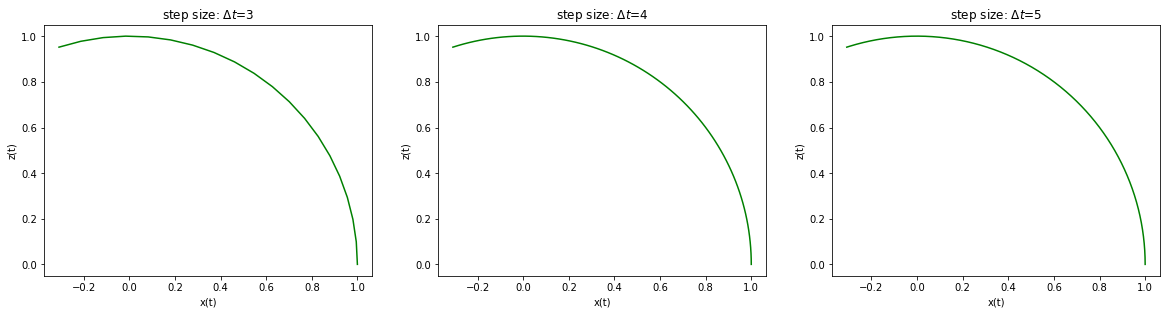

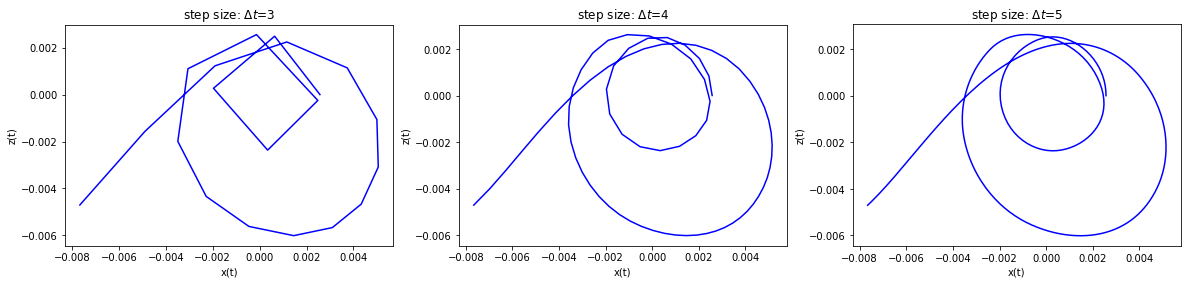

In [463]:
plot_trajectories(trajectories)

In [464]:
def plot_energy(plot_info):
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    
    energy = plot_info[2]['energy'] - plot_info[2]['energy'][0]
    angular = plot_info[2]['angular'] - plot_info[2]['angular'][0]
    t = plot_info[2]['time']
    
    axs[0].plot(t, energy)
    axs[0].set_title('Total energy deviation: $H(t)-H(0)$')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('$H(t)-H(0)$')

    axs[1].plot(t, angular)
    axs[1].set_title('Total angular momentum deviation: $L(t)-L(0)$')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('$L(t)-L(0)$')

    plt.show()

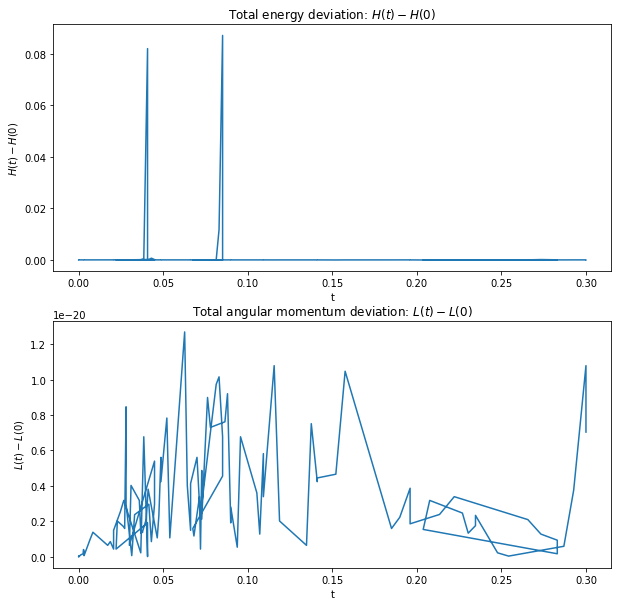

In [465]:
plot_energy(plot_info)